 <h1><center>Text Analytics Project </center></h1>
 <h1><center>Memes Classification [Sarcasam,Hate,Category] </center></h1>

<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#Section_1"> Importing Required Libraries and Data</a></li>
        <li><a href="#Section_2"> Program to extract labels, objects and text in the images from GOOGLE Vision API.</a></li>
        <li><a href="#Section_3"> Twitter Meme extraction Program </a> </li>
        <li><a href="#Section_4"> Loading and Preparing Data </a> </li>
     </ol>
</div>

For the Text Anlaytics project we want to build a classifier to detect Hate, Sarcasam and Category of Memes. Memes are short form of Text, Image or both which makes the reader laugh.For this project we have collected data from "Facebook.AI's" Hate memes detection competition dataset(https://www.drivendata.org/competitions/64/hateful-memes/) along with extracted meme's from Twitter using Twitter API. Along with the data we have, we  annotated data into Hate/Non-Hate, Sarcastic/Non-sarcastic and Multiclass categories of memes(Gender,Religion,Race,Nationality and others). We have collected around 10000 memes but were able to annotate approximately 6000 because of the complexity in meme understanding and time bound project submission.

We implemented Pytesseract to extract text data from the image but we didn't get fine text outputs. Thus we implemented Google API extraction. We came across labels,objects that Google API provides and extracted those to implement as a modality for our problem instead of text. 

# Importing Required Libraries and Data

In [1]:
#import dependencies
import os
import re
import pandas as pd
import cv2
import pytesseract
import matplotlib.pyplot as plt
from pytesseract import Output
import nltk
from nltk import FreqDist
from textblob import TextBlob
import seaborn as sns
import xlrd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize
import gensim

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\saisu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\saisu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Program to extract labels, objects and text in the images from GOOGLE Vision API.

In [2]:
# Please refer to folder- Google_api_text_label_extractor of this drive- 
# Ran as a independent fprogram from command line using Keyfile.json api key.

In [2]:
# #Do not run this cell 

# set Google API key file ->keyFile.json

#set GOOGLE_APPLICATION_CREDENTIALS = keyFile.json
#set GOOGLE_APPLICATION_CREDENTIALS=C:\Users\saisu\Desktop\Memes-classification\meme-detection\keyFile.json

#cd C:\Users\saisu\Desktop\Memes-classification\meme-detection

# python Googl-cloud-connection-file.py (Python Program)
import io
import os
import json
import pandas as pd
from google.cloud import vision
from itertools import product
from google.cloud.vision import types

client = vision.ImageAnnotatorClient()
#empty df to update text/lables/objects from API

df=pd.DataFrame(columns=['Image_id','Text','label_list','object_list'])
#Folder_path=r'C:\Users\saisu\Desktop\Memes-classification\meme-detection\sample2'
Folder_path=r'C:\Users\saisu\Desktop\Memes-classification\meme-detection\img'

#function image to text,labels and bjects
def image_to_text(FILE_NAME):
    with io.open(os.path.join(Folder_path,FILE_NAME),'rb') as image_file:
        content = image_file.read()

    image = types.Image(content=content)
    response = client.text_detection(image=image)#text extraction response
    response2 = client.label_detection(image=image)#label extraction response
    response3 = client.object_localization(image=image)#object extraction response
    texts=response.text_annotations
    labels = response2.label_annotations
    objects = response3.localized_object_annotations
    #texts[0].description=''
    label_list=[]
    for label in labels:
        label_list.append(label.description)
    object_list=[]
    for object in objects:
        object_list.append(object.name)
    return FILE_NAME,texts[0].description,label_list,object_list

#for every image in directory
for File in os.listdir(Folder_path):
    try:
        FILE_NAME, text,label_list,object_list =image_to_text(File)
        df = df.append(dict(Image_id=FILE_NAME,Text=text,label_list=label_list,object_list=object_list),ignore_index=True)
    except:
        continue

#export to csv
df.to_csv(r'image_to_text_output_sample.csv', index = False)

# Twitter Meme extraction Program

After getting the above file we split the data between teammates to label into Hate/Non-Hate, Sarcatic/Non-sarcastic, Categories- Gender,Religion,Race,Nationality and others. 

Below are the returned files.

# Loading and preparing Data

In [3]:
#concatenate annotated data
Nag=pd.read_excel("C:/Users/saisu/Desktop/Memes-classification/Labels/image_to_text_output_nagarjuna.xlsx",encoding='utf8',sheet_name='Nagarjuna')
sur=pd.read_excel("C:/Users/saisu/Desktop/Memes-classification/Labels/image_to_text_output_Suraj.xlsx",encoding='utf8',sheet_name='Suraj')
ash=pd.read_csv("C:/Users/saisu/Desktop/Memes-classification/Labels/image_to_text_output_ashrit.csv",encoding='utf8')
#drop unnecessary columns
Nag=Nag.drop(columns=['Unnamed: 4'])
sur=sur.drop(columns=['Unnamed: 5','label'])
ash=ash.drop(columns=['label'])
Nag_sur_ash=pd.concat([Nag,sur,ash])

In [4]:
# reading FB hate labels from json and preprocessing image col

df_train_main = pd.read_json("C:/Users/saisu/Desktop/Memes-classification/Labels/train.jsonl", lines = True)
df_test_main = pd.read_json("C:/Users/saisu/Desktop/Memes-classification/Labels/test.jsonl", lines= True)
df_train_main['img'] = df_train_main['img'].apply(lambda x: re.sub('img\/','',x))
df_test_main['img'] = df_test_main['img'].apply(lambda x: re.sub('img\/','',x))
df_train_main=df_train_main.drop(columns=['id'])
df_test_main=df_test_main.drop(columns=['id'])

In [5]:
df_google_raw =pd.read_csv("C:/Users/saisu/Desktop/Memes-classification/Labels/Full_data.csv")
df_google_raw=df_google_raw.drop(columns=['Unnamed: 0'])

In [6]:
#df_google_raw.rename('Text':'google_raw_text')
df_google_raw.rename(columns={'Text': 'google_raw_text'}, inplace=True)

In [7]:
df_train_test=pd.concat([df_train_main,df_test_main])
df_train_test.rename(columns={'text': 'FB_text','img': 'Image_id'}, inplace=True)
df_train_test=pd.merge(df_train_test, df_google_raw, on='Image_id')

In [8]:
df_train_test=pd.merge(df_train_test, Nag_sur_ash, on='Image_id')

In [9]:
df_train_test.rename(columns={'label': 'Hate_label','Text': 'Semi_cleaned_text'}, inplace=True)
df_train_test=df_train_test.dropna()
df_train_test['Hate_label']=df_train_test['Hate_label'].astype(int)
#df_train_test['Sarcasm_label']=df_train_test['Sarcasm_label'].astype(int)
#df_train_test['Category']=df_train_test['Category'].astype(int)

In [10]:
# df_train_test.to_csv('df_train_test.csv')

In [12]:
df_train_test.dropna()

,Image_id,Hate_label,FB_text,google_raw_text,label_list,object_list,Semi_cleaned_text,Sarcasm_label,Category
0,42953.png,0,its their character not their color that matters,its their character\nnọt their color\nthat mat...,"['Photo caption', 'Forehead', 'Internet meme',...","['Person', 'Person', 'Clothing']",its their character\nná»t their color\nthat m...,0,3
1,13894.png,0,putting bows on your pet,putting bows on your pet\n,"['Cat', 'Small to medium-sized cats', 'Mammal'...","['Cat', 'Bowtie', 'Cat']",putting bows on your pet\n,0,5
2,37408.png,0,i love everything and everybody! except for sq...,i love everything and everybody!\nexcept for s...,"['Dog', 'Mammal', 'Vertebrate', 'Dog breed', '...","['Dog', 'Dog']",i love everything and everybody!\nexcept for s...,0,5
3,82403.png,0,"everybody loves chocolate chip cookies, even h...","everybody loves chocolate\nchip cookies, even ...","['Text', 'Font', 'Photo caption', 'Photography...","['Person', 'Clothing']","everybody loves chocolate\nchip cookies, even ...",1,5
4,16952.png,0,go sports! do the thing! win the points!,pan\n71\ngo sports! do the thing! win the poin...,"['Sports', 'Basketball player', 'Player', 'Tea...","['Shorts', 'Shorts', 'Shorts', 'Person', 'Shoe...",pan\n71\ngo sports! do the thing! win the poin...,0,5
...,...,...,...,...,...,...,...,...,...
7271,83052.png,1,when your sister only bangs black guys and get...,when your sister only bangs black\nguys and ge...,"['Facial expression', 'Photo caption', 'Common...","['Person', 'Person']",when your sister only bangs black\nguys and ge...,1,3
7272,10423.png,1,nobody wants to hang auschwitz me,nobody wants to\nhang auschwitz-me\n,"['Photo caption', 'Font', 'Photography', 'Adap...",['Person'],nobody wants to\nhang auschwitz-me\n,1,5
7274,36947.png,1,gays on social media: equality! body positivit...,gays on social edia:\nCUNFI\nTettuality! body ...,"['Hair', 'Hairstyle', 'Face', 'Black hair', 'B...",['Person'],gays on social edia:\nequality! body positivit...,0,1
7275,16492.png,1,having a bad day? you could be a siamese twin ...,having a bad day?\nyou could be a siamese twin...,"['Photo caption', 'Internet meme', 'Font', 'Me...","['Person', 'Tie', 'Outerwear']",having a bad day?\nyou could be a siamese twin...,1,1


### After dropping NA's we had 4455 memes and semi-cleaned text is our text to clean and process for memes. we maually cleaned some of the text while labelling. since the Google API was rading the background noise.

# Pytesseract Textv extraction OCR fro Image implementation 

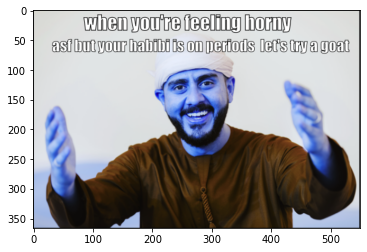

In [11]:
im = cv2.imread('C:/Users/nagar/OneDrive/Desktop/Facebook meme data/data/img' +'/' + str(df_train['img'][0]))
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
plt.imshow(im)

In [63]:
custom_config = r'--oem 3 --psm 6'
pytesseract.image_to_string(im,config = custom_config)

'When NOUTS feeline horn\nasi DI Vowr Tabi is on patiods lets tia goat\n(AC ¥\n\x0c'

In [12]:
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)

def show(image):
    return plt.imshow(image)

def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]



In [13]:
noise = remove_noise(im)
gscale = get_grayscale(noise)
thresh = thresholding(gscale)

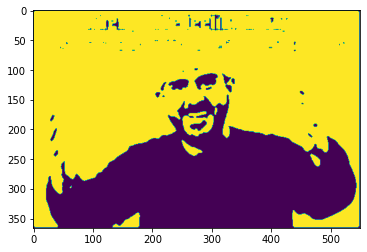

In [17]:
show(thresh)

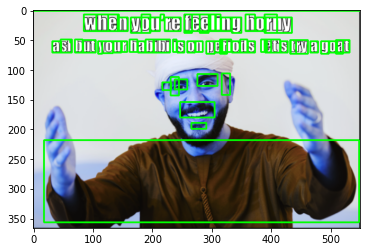

In [21]:
h, w, c = im.shape
boxes = pytesseract.image_to_boxes(im) 
for b in boxes.splitlines():
    b = b.split(' ')
    img = cv2.rectangle(im, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

show(img)

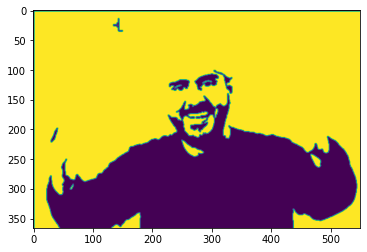

In [66]:
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Morph open to remove noise
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

# Find contours and remove small noise
cnts = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    area = cv2.contourArea(c)
    if area < 50:
        cv2.drawContours(opening, [c], -1, 0, -1)

# Invert and apply slight Gaussian blur
result = 255 - opening
result = cv2.GaussianBlur(result, (3,3), 0)

# Perform OCR
data = pytesseract.image_to_string(result, lang='eng', config='--psm 6')
print(data)

show(thresh)
show(opening)
show(result)

